In [128]:
import pandas as pd
import numpy as np
import helpers
import re

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas_profiling

from sklearn.metrics import classification_report

from joblib import load, dump


In [56]:
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')
df.shape

(39644, 61)

In [57]:
df.sample(5)

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
499,http://mashable.com/2013/01/15/snowmen-slow-mo...,723.0,8.0,286.0,0.561404,1.0,0.602941,18.0,2.0,15.0,...,0.250000,0.7,-0.342692,-0.6,-0.076923,0.400000,-0.300000,0.100000,0.300000,480
11036,http://mashable.com/2013/08/06/encrypt-faceboo...,520.0,14.0,333.0,0.648485,1.0,0.850746,5.0,3.0,0.0,...,0.100000,0.9,-0.261699,-0.5,-0.076923,0.400000,-0.400000,0.100000,0.400000,783
16525,http://mashable.com/2013/11/22/life-on-ipad/,412.0,10.0,741.0,0.506868,1.0,0.675799,19.0,6.0,1.0,...,0.033333,1.0,-0.213194,-0.5,-0.100000,0.454545,0.136364,0.045455,0.136364,1800
12228,http://mashable.com/2013/08/28/tech-commercial...,498.0,11.0,1175.0,0.397933,1.0,0.614286,5.0,1.0,1.0,...,0.050000,0.8,-0.223250,-0.5,-0.071429,0.000000,0.000000,0.500000,0.000000,7600
28034,http://mashable.com/2014/06/30/three-missing-i...,191.0,12.0,1709.0,0.359172,1.0,0.527862,5.0,1.0,4.0,...,0.050000,1.0,-0.306468,-0.4,-0.050000,0.560606,0.234848,0.060606,0.234848,1200


In [62]:
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]

# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']

# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)

channel = df.filter(regex='^data_', axis=1)

days = df.filter(regex=re.compile("weekday|weekend"), axis=1)

sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"),axis=1)

lda = df.filter(regex='^LDA_\d', axis=1)

keywords = df.filter(regex='^kw_', axis=1)

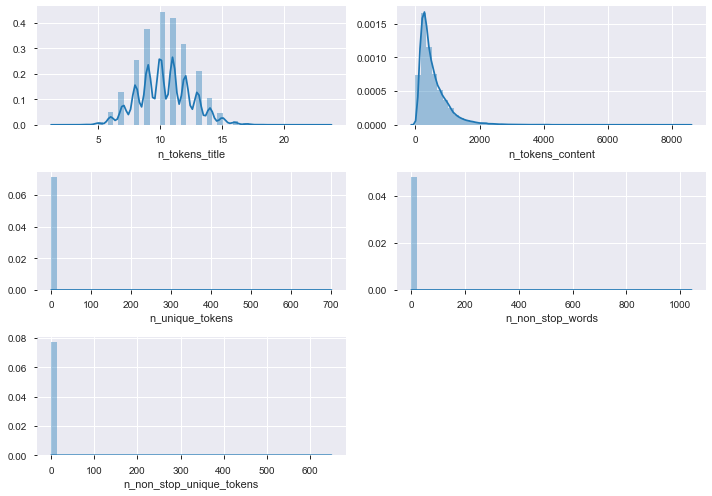

In [5]:
plt.figure(figsize = (10,7))
helpers.grid_plot_batch(qnty, 2, sn.distplot)

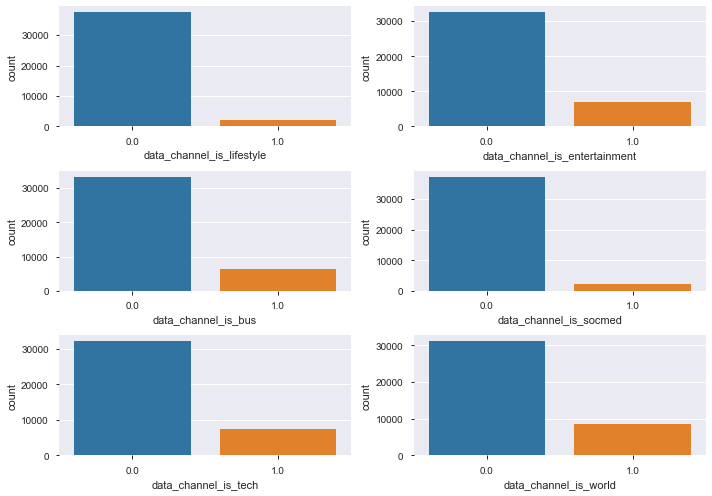

In [102]:
plt.figure(figsize = (10,7))
helpers.grid_plot_batch(channel, 2, sn.countplot)

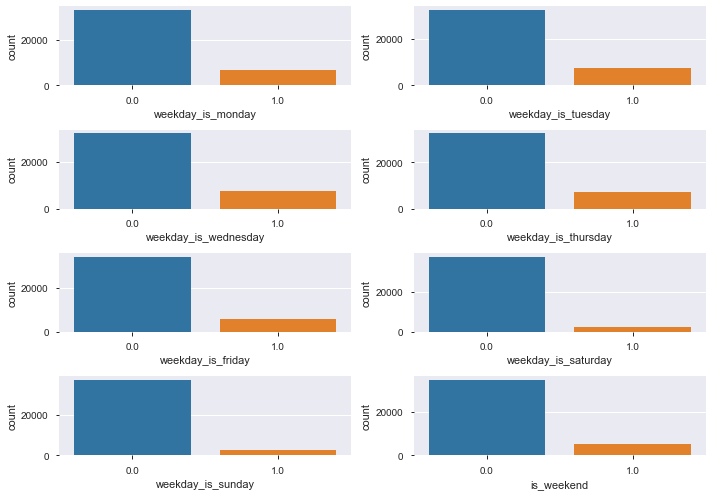

In [64]:
plt.figure(figsize = (10,7))
helpers.grid_plot_batch(days, 2, sn.countplot)

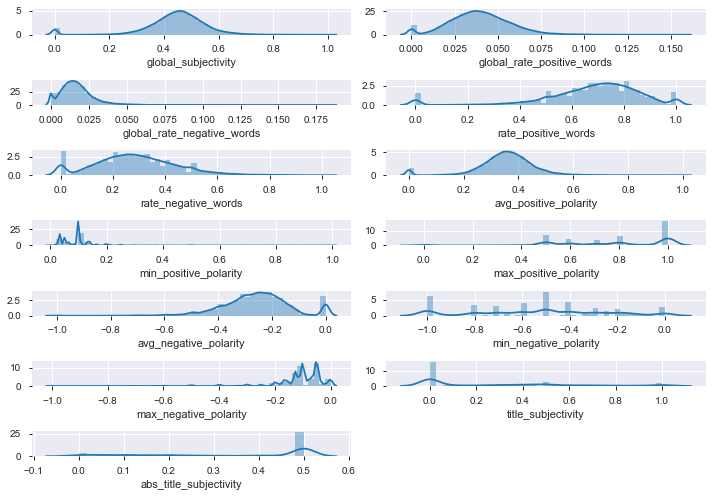

In [65]:
plt.figure(figsize = (10,7))
helpers.grid_plot_batch(sentiments, 2, sn.distplot)

In [66]:
correlations = helpers.identify_high_correlations(df, threshold=0.8)
correlations

,variable,var2,value
179,n_non_stop_words,n_unique_tokens,0.999572
238,n_non_stop_unique_tokens,n_unique_tokens,0.999852
239,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1139,kw_avg_min,kw_max_min,0.940529
1256,kw_max_max,kw_min_min,-0.857226
1499,kw_avg_avg,kw_max_avg,0.811864
1678,self_reference_avg_sharess,self_reference_min_shares,0.818907
1679,self_reference_avg_sharess,self_reference_max_shares,0.853480
2159,is_weekend,weekday_is_sunday,0.701648
2196,LDA_00,data_channel_is_bus,0.774651


In [15]:
df.drop(columns=correlations.variable, axis = 1, inplace = True)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('shares', axis = 1), df['shares'],
                                                   test_size = .30,
                                                   random_state = 11235813)

In [32]:
categorical_train = x_train.filter(regex = '_is_', axis = 1)
numeric_train = x_train.drop(categorical_train.columns, axis = 1)

categorical_test = x_test.filter(regex = '_is_', axis = 1)
numeric_test = x_test.drop(categorical_test.columns, axis = 1)

In [71]:
y_train_bin = np.where(y_train > 1400, 1, 0)
y_test_bin = np.where(y_test > 1400, 1, 0)

In [153]:
from sklearn.decomposition import PCA
pca = PCA(n_components = .99, svd_solver = 'full').fit(numeric_train)

In [154]:
numerical_pca_train = pca.transform(numeric_train)
numerical_pca_test = pca.transform(numeric_test)


In [155]:
final_train = pd.concat([
    pd.DataFrame(numerical_pca_train),
    categorical_train.reset_index(drop = True)],
    axis = 1)

In [156]:
final_test = pd.concat([
    pd.DataFrame(numerical_pca_test),
    categorical_test.reset_index(drop = True)],
    axis = 1)

In [157]:
final_train.drop('shares_bin', axis = 1, inplace = True)
final_test.drop('shares_bin', axis = 1, inplace = True)

------
# Modelamiento

## Logistic Regression

In [158]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression().fit(final_train, y_train_bin)

/Users/ignacio/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [159]:
print(classification_report(y_test_bin, logit.predict(final_test)))

              precision    recall  f1-score   support

           0       0.55      0.88      0.68      6005
           1       0.69      0.27      0.38      5889

    accuracy                           0.58     11894
   macro avg       0.62      0.57      0.53     11894
weighted avg       0.62      0.58      0.53     11894



In [160]:
dump(logit, 'logit_pauta.joblib')

['logit_pauta.joblib']

------
## Decision Tree

In [161]:
tree_test = DecisionTreeClassifier().fit(x_train, y_train_bin)
print(classification_report(y_test_bin, tree_test.predict(x_test)))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      6005
           1       0.56      0.56      0.56      5889

    accuracy                           0.57     11894
   macro avg       0.57      0.57      0.57     11894
weighted avg       0.57      0.57      0.57     11894



In [162]:
df_importances = pd.DataFrame([x_test.columns, tree_test.feature_importances_]).T
df_importances.columns = ['Column', 'Importance']
df_importances.sort_values(by = 'Importance', ascending = False)

,Column,Importance
25,kw_avg_avg,0.0743866
22,kw_avg_max,0.0428244
24,kw_max_avg,0.0369692
9,average_token_length,0.0343693
28,self_reference_avg_sharess,0.0331944
38,LDA_01,0.0321023
37,LDA_00,0.0313172
2,n_unique_tokens,0.0294314
19,kw_avg_min,0.0291946
26,self_reference_min_shares,0.0290071


In [163]:
from sklearn.tree import DecisionTreeClassifier

tree_1 = DecisionTreeClassifier(max_depth=1).fit(final_train, y_train_bin)
tree_10 = DecisionTreeClassifier(max_depth=10).fit(final_train, y_train_bin)

In [164]:
print('##################### Max Depth = 1 #####################')
print(classification_report(y_test_bin, tree_1.predict(final_test)))
print('\n##################### Max Depth = 4 #####################')
print(classification_report(y_test_bin, tree_10.predict(final_test)))

##################### Max Depth = 1 #####################
              precision    recall  f1-score   support

           0       0.64      0.27      0.38      6005
           1       0.53      0.85      0.65      5889

    accuracy                           0.56     11894
   macro avg       0.59      0.56      0.52     11894
weighted avg       0.59      0.56      0.52     11894


##################### Max Depth = 4 #####################
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      6005
           1       0.61      0.65      0.63      5889

    accuracy                           0.62     11894
   macro avg       0.62      0.62      0.62     11894
weighted avg       0.62      0.62      0.62     11894



In [165]:
dump(tree_1, 'tree_1_pauta.joblib')
dump(tree_10, 'tree_10_pauta.joblib')

['tree_10_pauta.joblib']

----

## SVM

In [166]:
from sklearn.svm import SVC

svm = SVC(gamma = 'auto').fit(final_train, y_train_bin)

In [167]:
print(classification_report(y_test_bin, svm.predict(final_test)))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67      6005
           1       0.50      0.00      0.01      5889

    accuracy                           0.50     11894
   macro avg       0.50      0.50      0.34     11894
weighted avg       0.50      0.50      0.34     11894



In [168]:
dump(svm, 'svm_pauta.joblib')

['svm_pauta.joblib']

-----
## GradientBoost

In [169]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier().fit(final_train, y_train_bin)

In [170]:
print(classification_report(y_test_bin, gboost.predict(final_test)))


              precision    recall  f1-score   support

           0       0.64      0.65      0.64      6005
           1       0.64      0.63      0.63      5889

    accuracy                           0.64     11894
   macro avg       0.64      0.64      0.64     11894
weighted avg       0.64      0.64      0.64     11894



In [171]:
dump(gboost, 'gboost_pauta.joblib')

['gboost_pauta.joblib']

-----
## RandonForest

In [172]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 60, n_jobs = -1).fit(final_train, y_train_bin)

In [173]:
print(classification_report(y_test_bin, rf.predict(final_test)))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61      6005
           1       0.60      0.58      0.59      5889

    accuracy                           0.60     11894
   macro avg       0.60      0.60      0.60     11894
weighted avg       0.60      0.60      0.60     11894



In [174]:
dump(rf, 'rf_pauta.joblib')

['rf_pauta.joblib']

------
## VotingClassifier (sklearn)

In [175]:
from sklearn.ensemble import VotingClassifier

models = [('RandomForest',rf), ('GradientBoost',gboost),('Logit',logit), ('DecisionTree_1',tree_1),
          ('DecisionTree_10', tree_10), ('SVM', svm)]
comite = VotingClassifier(models, n_jobs = -1).fit(final_train, y_train_bin)

In [176]:
print(classification_report(y_test_bin, comite.predict(final_test)))

              precision    recall  f1-score   support

           0       0.60      0.77      0.67      6005
           1       0.67      0.47      0.55      5889

    accuracy                           0.62     11894
   macro avg       0.63      0.62      0.61     11894
weighted avg       0.63      0.62      0.61     11894



-----
## VotingClassifier (mlxtend)

In [177]:
from mlxtend.classifier import EnsembleVoteClassifier

rf_loaded = load('rf_pauta.joblib')
logit_loaded = load('logit_pauta.joblib')
gboost_loaded = load('gboost_pauta.joblib')
tree_1_loaded = load('tree_1_pauta.joblib')
tree_10_loaded = load('tree_10_pauta.joblib')
svm_loaded = load('svm_pauta.joblib')

In [178]:
models_2 = [rf_loaded, logit_loaded, gboost_loaded, tree_1_loaded, tree_10_loaded, svm_loaded]

comite_mlxtend = EnsembleVoteClassifier(models_2, refit = False).fit(final_train, y_train_bin)

In [179]:
print(classification_report(y_test_bin, comite_mlxtend.predict(final_test)))

              precision    recall  f1-score   support

           0       0.60      0.77      0.67      6005
           1       0.67      0.47      0.55      5889

    accuracy                           0.62     11894
   macro avg       0.63      0.62      0.61     11894
weighted avg       0.63      0.62      0.61     11894

